In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [13]:
import pandas as pd
import numpy as np

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from pprint import pprint as pp

In [16]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [17]:
#import importlib
from helper_methods import plot_confusion_matrices, make_dataframes_from_classification_report
from helper_methods import plot_classification_report, plot_model_summary_metrics
from helper_methods import plot_small_classes_metric

In [18]:
#import importlib
#importlib.reload(helper_methods)

# OBJECTIVE
Quick investigation of severeal tree models using default parameters:
- decision tree
- random forest
- gradient boosting (GB)
- XGBoost
- Light GBM
- CatBoost

# CONCLUSIONS
overall model peformance
- GB, XGBoost, LightGBM, and CatBoost have almost identical performance
- their performance is better than decision tree and random forest

performance by class
- random forest does not predict any instances of the 4 smallest classes
- decision tree performance on 4 smallest classes is poorer than on 3 largest classes

GB, XGBoost, LightGBM, and CatBoost on 4 smallest classes
- generally have better precision than recall
- XGBoost has slightly better precision and recall than others
- CatBoost generally performs worse than others

LightGBM and CatBoost
- can directly use the 2 categorical features
- very similar performance
- LightGBM slightly better for precision
- CatBoost slightly better for recall

next steps
- parameter tuning for XGBoost and CatBoost

# reference material
decision trees general: https://scikit-learn.org/stable/modules/tree.html   
ensemble methods general: https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting

# logical to control dataset sizes for modeling
### `True` gives very small train and test set sizes for developing and debugging notebook
### `False` splits entire dataset into train and test

In [19]:
#use_small_data_set = True
use_small_data_set = False

# read wrangled data from pickle

In [20]:
df_data = pd.read_pickle('data/wrangled_data.pkl')

In [21]:
df_data.shape
df_data.columns
df_data.head()

(581012, 68)

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wild_area_rawah', 'wild_area_neota',
       'wild_area_comanche_peak', 'wild_area_cache_la_poudre', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_35', 'soil_type_36', 'soil_type_37',
       'soil_type_38', 'soil_type_39', 'soil_type_40', 'cover_type',
       'wilder

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,...,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points
0,2596,51,3,258,0,510,221,232,148,6279,...,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,2590,56,2,212,-6,390,220,235,151,6225,...,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2804,139,9,268,65,3180,234,238,135,6121,...,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2785,155,18,242,118,3090,238,238,122,6211,...,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,2595,45,2,153,-1,391,220,234,150,6172,...,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449


### define lists of column names

In [22]:
column = 'wild_area_'
areas = ['rawah', 'neota', 'comanche_peak', 'cache_la_poudre']
wild_area_cols = []
for i in areas:
    wild_area_cols.append(column + i)

column = 'soil_type_'
soil_type_cols = []
for i in range(1,41):
    soil_type_cols.append(column + str(i))

numerical_cols = ['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology', 'HD_roadways',
                  'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'HD_fire_points']

scaled_numerical_cols = []
for col in numerical_cols:
    scaled_numerical_cols.append('mms_' + col)

target_col = ['cover_type']

target_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']

reverse_one_hot_cols = ['wilderness_index', 'wilderness_area', 'soil_index']
categorical_cols = ['wilderness_index', 'soil_index']

print('numerical_cols:')
pp(numerical_cols)

print('\nscaled_numerical_cols:')
pp(scaled_numerical_cols)

print('\nwild_area_cols:')
pp(wild_area_cols)

print('\nsoil_type_cols:')
pp(soil_type_cols)

print('\nreverse_one_hot_cols:')
pp(reverse_one_hot_cols)

print('\ncategorical_cols:')
pp(categorical_cols)

print('\ntarget_col:')
pp(target_col)

print('\ntarget_names:')
pp(target_names)

numerical_cols:
['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points']

scaled_numerical_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points']

wild_area_cols:
['wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre']

soil_type_cols:
['soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 's

In [23]:
len(df_data.columns)

68

In [24]:
len(numerical_cols + scaled_numerical_cols + wild_area_cols + soil_type_cols + reverse_one_hot_cols + target_col)

68

In [25]:
feature_cols_no_cat   = scaled_numerical_cols + wild_area_cols + soil_type_cols
feature_cols_with_cat = scaled_numerical_cols + categorical_cols
feature_cols_to_split = scaled_numerical_cols + wild_area_cols + soil_type_cols + categorical_cols

print('\nfeature_cols_no_cat:')
pp(feature_cols_no_cat)

print('\nfeature_cols_with_cat:')
pp(feature_cols_with_cat)

print('\nfeature_cols_to_split:')
pp(feature_cols_to_split)


feature_cols_no_cat:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points',
 'wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 'soil_type_29',
 'soil_type_30',
 'soil_type_31',
 'soil_type_32',
 'soil_type_33',
 'soil_type_34',
 'soil_type_35',
 'soil_type_36',
 'soil_type_37',
 'soil_type_38',
 'soil_type_39',
 'soil_type_40']

feature_c

# function to get target name from target integer value

In [26]:
get_target_name_from_integer = lambda i : target_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

# train-test split

In [27]:
if use_small_data_set:
    train_sample_size = 5000
    test_sample_size  = 1500

    X_train_all, X_test_all, y_train, y_test = train_test_split(df_data[feature_cols_to_split], df_data[target_col[0]],
                                       train_size=train_sample_size, test_size=test_sample_size, random_state=59)

else:
    X_train_all, X_test_all, y_train, y_test = train_test_split(df_data[feature_cols_to_split], df_data[target_col[0]],
                                       train_size=0.7, random_state=59)
    

In [28]:
X_train_all.shape
X_test_all.shape

(406708, 56)

(174304, 56)

### use of categorical features
- models that CAN NOT directly use categorical features: `feature_cols_no_cat`   
- models that CAN directly use categorical features: `feature_cols_with_cat`

In [29]:
print('number features, no cat = ', len(feature_cols_no_cat))
X_train_all[feature_cols_no_cat].head()

number features, no cat =  54


,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points,...,soil_type_31,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40
511216,0.647324,0.186111,0.242424,0.183250,0.250646,0.192216,0.925197,0.811024,0.385827,0.330685,...,0,0,0,0,0,0,0,0,1,0
234324,0.439720,0.516667,0.257576,0.021475,0.229974,0.174652,0.866142,0.984252,0.618110,0.271853,...,0,0,0,0,0,0,0,0,0,0
446270,0.689845,0.036111,0.060606,0.334288,0.485788,0.395672,0.846457,0.909449,0.598425,0.410149,...,1,0,0,0,0,0,0,0,0,0
50042,0.450225,0.919444,0.090909,0.088762,0.226098,0.316004,0.811024,0.917323,0.649606,0.551373,...,0,0,0,0,0,0,0,0,0,0
549678,0.777889,0.650000,0.318182,0.042949,0.223514,0.298019,0.708661,0.996063,0.807087,0.478321,...,0,1,0,0,0,0,0,0,0,0


In [30]:
print('number features, with cat = ', len(feature_cols_with_cat))
X_train_all[feature_cols_with_cat].head()

number features, with cat =  12


,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points,wilderness_index,soil_index
511216,0.647324,0.186111,0.242424,0.183250,0.250646,0.192216,0.925197,0.811024,0.385827,0.330685,2,39
234324,0.439720,0.516667,0.257576,0.021475,0.229974,0.174652,0.866142,0.984252,0.618110,0.271853,2,13
446270,0.689845,0.036111,0.060606,0.334288,0.485788,0.395672,0.846457,0.909449,0.598425,0.410149,2,31
50042,0.450225,0.919444,0.090909,0.088762,0.226098,0.316004,0.811024,0.917323,0.649606,0.551373,0,12
549678,0.777889,0.650000,0.318182,0.042949,0.223514,0.298019,0.708661,0.996063,0.807087,0.478321,1,32


### distribution of target values

In [31]:
target_values = df_data[target_col]
target_dist_orig = target_values.value_counts() / len(target_values)
#target_dist_orig

target_values = pd.DataFrame(y_train)
target_dist_train = target_values.value_counts() / len(target_values)
#target_dist_train

target_values = pd.DataFrame(y_test)
target_dist_test = target_values.value_counts() / len(target_values)
#target_dist_test

df_target_dist = pd.DataFrame(zip(target_dist_orig, target_dist_train, target_dist_test),
                              columns=['original', 'train', 'test'],
                              index=target_dist_orig.reset_index()[target_col[0]].values)
#df_target_dist

df_target_dist = df_target_dist.reset_index().rename(columns={'index':target_col[0]})
#df_target_dist

df_target_dist['target_name'] = df_target_dist[target_col[0]].apply(get_target_name_from_integer)

df_target_dist

,cover_type,original,train,test,target_name
0,2,0.487599,0.487586,0.487631,lodgepole_pine
1,1,0.364605,0.364596,0.364627,spruce_fir
2,3,0.061537,0.061622,0.061341,ponderosa_pine
3,7,0.035300,0.035404,0.035059,krummholz
4,6,0.029891,0.029955,0.029741,douglas_fir
5,5,0.016339,0.016115,0.016861,aspen
6,4,0.004728,0.004723,0.004739,cottonwood_willow


# variables to hold modeling results

In [84]:
df_report_by_class = pd.DataFrame()
df_report_summary  = pd.DataFrame()
y_pred_by_model = {}
list_model_names = []
list_the_models  = []

# decision tree classifier
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [85]:
model_name = 'decision_tree'
list_model_names.append(model_name)

X_train = X_train_all[feature_cols_no_cat]
X_test  = X_test_all[feature_cols_no_cat]

In [86]:
dt = DecisionTreeClassifier(max_depth=4, random_state=59)
dt.fit(X_train, y_train)

list_the_models.append(dt)

DecisionTreeClassifier(max_depth=4, random_state=59)

### predictions

In [87]:
y_train_pred = dt.predict(X_train)
y_test_pred  = dt.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframe for classification report

In [88]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,decision_tree,train,spruce_fir,0.683511,0.669175,0.676267,148284
2,decision_tree,train,lodgepole_pine,0.725781,0.792032,0.757461,198305
3,decision_tree,train,ponderosa_pine,0.633379,0.857394,0.728555,25062
4,decision_tree,train,cottonwood_willow,0.494201,0.399271,0.441693,1921
5,decision_tree,train,aspen,0.000000,0.000000,0.000000,6554
6,decision_tree,train,douglas_fir,0.718241,0.036198,0.068922,12183
7,decision_tree,train,krummholz,0.697067,0.437391,0.537510,14399
1,decision_tree,test,spruce_fir,0.682179,0.672541,0.677326,63556
2,decision_tree,test,lodgepole_pine,0.725286,0.789814,0.756176,84996
3,decision_tree,test,ponderosa_pine,0.632578,0.851010,0.725714,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,decision_tree,train,0.701452,0.564597,0.455923,0.458630,0.690643,0.701452,0.683966
1,decision_tree,test,0.700477,0.566415,0.456152,0.458013,0.689867,0.700477,0.682831


# random forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  

In [89]:
model_name = 'random_forest'
list_model_names.append(model_name)

X_train = X_train_all[feature_cols_no_cat]
X_test  = X_test_all[feature_cols_no_cat]

In [90]:
rf = RandomForestClassifier(max_depth=4, random_state=59)
rf.fit(X_train, y_train)

list_the_models.append(rf)

RandomForestClassifier(max_depth=4, random_state=59)

### predictions

In [91]:
y_train_pred = rf.predict(X_train)
y_test_pred  = rf.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [92]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,decision_tree,train,spruce_fir,0.683511,0.669175,0.676267,148284
2,decision_tree,train,lodgepole_pine,0.725781,0.792032,0.757461,198305
3,decision_tree,train,ponderosa_pine,0.633379,0.857394,0.728555,25062
4,decision_tree,train,cottonwood_willow,0.494201,0.399271,0.441693,1921
5,decision_tree,train,aspen,0.000000,0.000000,0.000000,6554
6,decision_tree,train,douglas_fir,0.718241,0.036198,0.068922,12183
7,decision_tree,train,krummholz,0.697067,0.437391,0.537510,14399
1,decision_tree,test,spruce_fir,0.682179,0.672541,0.677326,63556
2,decision_tree,test,lodgepole_pine,0.725286,0.789814,0.756176,84996
3,decision_tree,test,ponderosa_pine,0.632578,0.851010,0.725714,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,decision_tree,train,0.701452,0.564597,0.455923,0.458630,0.690643,0.701452,0.683966
1,decision_tree,test,0.700477,0.566415,0.456152,0.458013,0.689867,0.700477,0.682831
1,random_forest,train,0.672040,0.277085,0.296079,0.286076,0.614013,0.672040,0.641583
1,random_forest,test,0.671614,0.276415,0.295439,0.285402,0.613584,0.671614,0.641125


# gradient boosting
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier  

In [93]:
model_name = 'gradient_boosting'
list_model_names.append(model_name)

X_train = X_train_all[feature_cols_no_cat]
X_test  = X_test_all[feature_cols_no_cat]

In [94]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=59)
gb.fit(X_train, y_train)

list_the_models.append(gb)

GradientBoostingClassifier(random_state=59)

### predictions

In [95]:
y_train_pred = gb.predict(X_train)
y_test_pred  = gb.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [96]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,decision_tree,train,spruce_fir,0.683511,0.669175,0.676267,148284
2,decision_tree,train,lodgepole_pine,0.725781,0.792032,0.757461,198305
3,decision_tree,train,ponderosa_pine,0.633379,0.857394,0.728555,25062
4,decision_tree,train,cottonwood_willow,0.494201,0.399271,0.441693,1921
5,decision_tree,train,aspen,0.000000,0.000000,0.000000,6554
6,decision_tree,train,douglas_fir,0.718241,0.036198,0.068922,12183
7,decision_tree,train,krummholz,0.697067,0.437391,0.537510,14399
1,decision_tree,test,spruce_fir,0.682179,0.672541,0.677326,63556
2,decision_tree,test,lodgepole_pine,0.725286,0.789814,0.756176,84996
3,decision_tree,test,ponderosa_pine,0.632578,0.851010,0.725714,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,decision_tree,train,0.701452,0.564597,0.455923,0.458630,0.690643,0.701452,0.683966
1,decision_tree,test,0.700477,0.566415,0.456152,0.458013,0.689867,0.700477,0.682831
1,random_forest,train,0.672040,0.277085,0.296079,0.286076,0.614013,0.672040,0.641583
1,random_forest,test,0.671614,0.276415,0.295439,0.285402,0.613584,0.671614,0.641125
1,gradient_boosting,train,0.775955,0.777892,0.658111,0.695955,0.775309,0.775955,0.772396
1,gradient_boosting,test,0.772065,0.767458,0.644667,0.682713,0.771231,0.772065,0.768212


# XG boost
https://xgboost.readthedocs.io/en/latest/   
https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn   
https://xgboost.readthedocs.io/en/latest//parameter.html   
   
default values   
`n_estimators = 100`   
`max_depth = 3`

In [97]:
model_name = 'XGBoost'
list_model_names.append(model_name)

X_train = X_train_all[feature_cols_no_cat]
X_test  = X_test_all[feature_cols_no_cat]

In [98]:
xgb = XGBClassifier(n_estimators=100, max_depth=3, random_state=59)
#xgb.get_params()
xgb.fit(X_train, y_train)

list_the_models.append(xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=59, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### predictions

In [99]:
y_train_pred = xgb.predict(X_train)
y_test_pred  = xgb.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [100]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,decision_tree,train,spruce_fir,0.683511,0.669175,0.676267,148284
2,decision_tree,train,lodgepole_pine,0.725781,0.792032,0.757461,198305
3,decision_tree,train,ponderosa_pine,0.633379,0.857394,0.728555,25062
4,decision_tree,train,cottonwood_willow,0.494201,0.399271,0.441693,1921
5,decision_tree,train,aspen,0.000000,0.000000,0.000000,6554
6,decision_tree,train,douglas_fir,0.718241,0.036198,0.068922,12183
7,decision_tree,train,krummholz,0.697067,0.437391,0.537510,14399
1,decision_tree,test,spruce_fir,0.682179,0.672541,0.677326,63556
2,decision_tree,test,lodgepole_pine,0.725286,0.789814,0.756176,84996
3,decision_tree,test,ponderosa_pine,0.632578,0.851010,0.725714,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,decision_tree,train,0.701452,0.564597,0.455923,0.458630,0.690643,0.701452,0.683966
1,decision_tree,test,0.700477,0.566415,0.456152,0.458013,0.689867,0.700477,0.682831
1,random_forest,train,0.672040,0.277085,0.296079,0.286076,0.614013,0.672040,0.641583
1,random_forest,test,0.671614,0.276415,0.295439,0.285402,0.613584,0.671614,0.641125
1,gradient_boosting,train,0.775955,0.777892,0.658111,0.695955,0.775309,0.775955,0.772396
1,gradient_boosting,test,0.772065,0.767458,0.644667,0.682713,0.771231,0.772065,0.768212
1,XGBoost,train,0.782741,0.801131,0.675424,0.712000,0.782747,0.782741,0.778831
1,XGBoost,test,0.777704,0.791058,0.661121,0.698140,0.777680,0.777704,0.773514


### feature importance

In [101]:
xgb.feature_importances_

array([0.13268495, 0.01229264, 0.00652075, 0.02117082, 0.00765841,
       0.0140055 , 0.01009609, 0.02118381, 0.0092008 , 0.01161614,
       0.0531522 , 0.024677  , 0.02996513, 0.0247342 , 0.00217034,
       0.03364229, 0.01600746, 0.03212101, 0.00397941, 0.00433618,
       0.        , 0.01044467, 0.01052473, 0.00956771, 0.00763506,
       0.0333164 , 0.00918846, 0.00429926, 0.        , 0.01718052,
       0.01337799, 0.01004858, 0.00702831, 0.00967868, 0.01092324,
       0.05865853, 0.04449776, 0.00705852, 0.00965977, 0.00499508,
       0.00958212, 0.0029912 , 0.02966366, 0.02812427, 0.01353404,
       0.0332646 , 0.00986608, 0.00451239, 0.01437759, 0.0031364 ,
       0.00744417, 0.03279572, 0.04870278, 0.01270655], dtype=float32)

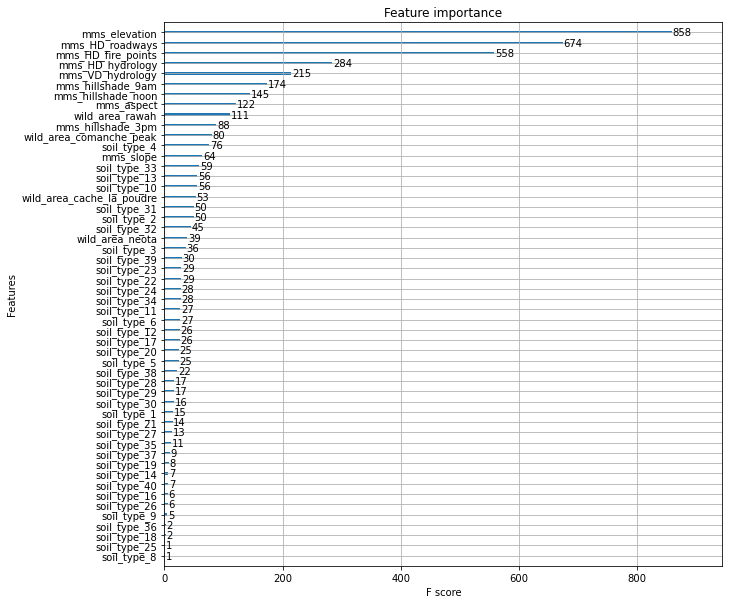

In [102]:
fig, ax = plt.subplots(1,1)
_ = fig.set_figheight(10)
_ = fig.set_figwidth(10)

_ = xgboost.plot_importance(xgb, ax=ax)

# LightGBM
https://lightgbm.readthedocs.io/en/latest/   
maybe an issue with feature importance of categorical features   
https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm   

default values   
`n_estimators = 100`  
`silent = True`

In [103]:
model_name = 'LightGBM'
list_model_names.append(model_name)

X_train = X_train_all[feature_cols_with_cat]
X_test  = X_test_all[feature_cols_with_cat]

ds_X_train = lightgbm.Dataset(X_train, categorical_feature=categorical_cols)
ds_X_test  = lightgbm.Dataset(X_test,  categorical_feature=categorical_cols)
#ds_X_train.data

In [104]:
lgbm = LGBMClassifier(max_depth=3, num_threads=1, random_state=59)
lgbm.fit(ds_X_train.data, y_train)

list_the_models.append(lgbm)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


LGBMClassifier(max_depth=3, num_threads=1, random_state=59)

### predictions

In [105]:
y_train_pred = lgbm.predict(ds_X_train.data)
y_test_pred  = lgbm.predict(ds_X_test.data)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [106]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,decision_tree,train,spruce_fir,0.683511,0.669175,0.676267,148284
2,decision_tree,train,lodgepole_pine,0.725781,0.792032,0.757461,198305
3,decision_tree,train,ponderosa_pine,0.633379,0.857394,0.728555,25062
4,decision_tree,train,cottonwood_willow,0.494201,0.399271,0.441693,1921
5,decision_tree,train,aspen,0.000000,0.000000,0.000000,6554
...,...,...,...,...,...,...,...
3,LightGBM,test,ponderosa_pine,0.725819,0.845024,0.780899,10692
4,LightGBM,test,cottonwood_willow,0.830320,0.722760,0.772816,826
5,LightGBM,test,aspen,0.805996,0.155495,0.260696,2939
6,LightGBM,test,douglas_fir,0.633379,0.353588,0.453825,5184


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,decision_tree,train,0.701452,0.564597,0.455923,0.458630,0.690643,0.701452,0.683966
1,decision_tree,test,0.700477,0.566415,0.456152,0.458013,0.689867,0.700477,0.682831
1,random_forest,train,0.672040,0.277085,0.296079,0.286076,0.614013,0.672040,0.641583
1,random_forest,test,0.671614,0.276415,0.295439,0.285402,0.613584,0.671614,0.641125
1,gradient_boosting,train,0.775955,0.777892,0.658111,0.695955,0.775309,0.775955,0.772396
1,gradient_boosting,test,0.772065,0.767458,0.644667,0.682713,0.771231,0.772065,0.768212
1,XGBoost,train,0.782741,0.801131,0.675424,0.712000,0.782747,0.782741,0.778831
1,XGBoost,test,0.777704,0.791058,0.661121,0.698140,0.777680,0.777704,0.773514
1,LightGBM,train,0.764406,0.770054,0.626336,0.660277,0.763614,0.764406,0.758453
1,LightGBM,test,0.760803,0.763777,0.617925,0.651599,0.760088,0.760803,0.754681


### feature importance

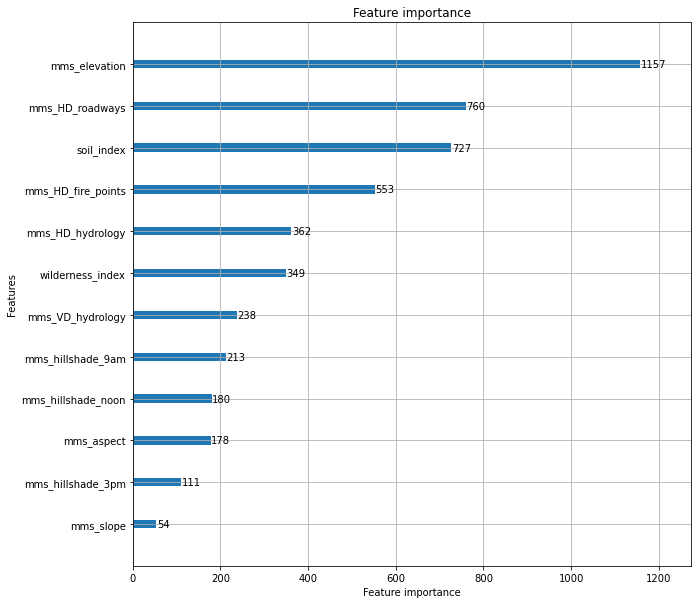

In [107]:
fig, ax = plt.subplots(1,1)
_ = fig.set_figheight(10)
_ = fig.set_figwidth(10)

_ = lightgbm.plot_importance(lgbm, ax=ax)

# CatBoost
https://catboost.ai/docs/  
default values   
`n_estimators = 1000`  
`max_depth = 6`   
`silent = True`

In [108]:
model_name = 'CatBoost'
list_model_names.append(model_name)

X_train = X_train_all[feature_cols_with_cat]
X_test  = X_test_all[feature_cols_with_cat]

In [109]:
cb = CatBoostClassifier(n_estimators=100, max_depth=3, cat_features=categorical_cols, random_state=59)
cb.fit(X_train, y_train)

list_the_models.append(cb)

Learning rate set to 0.5
0:	learn: 1.0679922	total: 277ms	remaining: 27.4s
1:	learn: 0.9400716	total: 528ms	remaining: 25.9s
2:	learn: 0.8649719	total: 823ms	remaining: 26.6s
3:	learn: 0.8052921	total: 1.06s	remaining: 25.5s
4:	learn: 0.7576219	total: 1.31s	remaining: 24.9s
5:	learn: 0.7286303	total: 1.54s	remaining: 24.1s
6:	learn: 0.7097848	total: 1.79s	remaining: 23.8s
7:	learn: 0.6978067	total: 2.05s	remaining: 23.5s
8:	learn: 0.6882687	total: 2.25s	remaining: 22.7s
9:	learn: 0.6804113	total: 2.46s	remaining: 22.2s
10:	learn: 0.6710683	total: 2.7s	remaining: 21.8s
11:	learn: 0.6647891	total: 2.94s	remaining: 21.6s
12:	learn: 0.6621784	total: 3.18s	remaining: 21.3s
13:	learn: 0.6558389	total: 3.44s	remaining: 21.2s
14:	learn: 0.6486369	total: 3.68s	remaining: 20.9s
15:	learn: 0.6413646	total: 3.91s	remaining: 20.5s
16:	learn: 0.6377800	total: 4.13s	remaining: 20.2s
17:	learn: 0.6355354	total: 4.35s	remaining: 19.8s
18:	learn: 0.6312002	total: 4.57s	remaining: 19.5s
19:	learn: 0.6258

### predictions

In [110]:
y_train_pred = cb.predict(X_train)
y_test_pred  = cb.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [111]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,decision_tree,train,spruce_fir,0.683511,0.669175,0.676267,148284
2,decision_tree,train,lodgepole_pine,0.725781,0.792032,0.757461,198305
3,decision_tree,train,ponderosa_pine,0.633379,0.857394,0.728555,25062
4,decision_tree,train,cottonwood_willow,0.494201,0.399271,0.441693,1921
5,decision_tree,train,aspen,0.000000,0.000000,0.000000,6554
...,...,...,...,...,...,...,...
3,CatBoost,test,ponderosa_pine,0.725591,0.818088,0.769068,10692
4,CatBoost,test,cottonwood_willow,0.761840,0.681598,0.719489,826
5,CatBoost,test,aspen,0.742523,0.194284,0.307983,2939
6,CatBoost,test,douglas_fir,0.597472,0.364776,0.452988,5184


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,decision_tree,train,0.701452,0.564597,0.455923,0.458630,0.690643,0.701452,0.683966
1,decision_tree,test,0.700477,0.566415,0.456152,0.458013,0.689867,0.700477,0.682831
1,random_forest,train,0.672040,0.277085,0.296079,0.286076,0.614013,0.672040,0.641583
1,random_forest,test,0.671614,0.276415,0.295439,0.285402,0.613584,0.671614,0.641125
1,gradient_boosting,train,0.775955,0.777892,0.658111,0.695955,0.775309,0.775955,0.772396
1,gradient_boosting,test,0.772065,0.767458,0.644667,0.682713,0.771231,0.772065,0.768212
1,XGBoost,train,0.782741,0.801131,0.675424,0.712000,0.782747,0.782741,0.778831
1,XGBoost,test,0.777704,0.791058,0.661121,0.698140,0.777680,0.777704,0.773514
1,LightGBM,train,0.764406,0.770054,0.626336,0.660277,0.763614,0.764406,0.758453
1,LightGBM,test,0.760803,0.763777,0.617925,0.651599,0.760088,0.760803,0.754681


### feature importance

In [112]:
cb.feature_importances_

array([39.55519027,  1.32282169,  0.6507523 ,  4.42659597,  1.24533823,
       13.35286117,  1.77670433,  1.86336028,  0.84104041, 10.37529833,
        7.63460138, 16.95543566])

In [113]:
df_cb_features = pd.DataFrame(zip(feature_cols_with_cat, cb.feature_importances_), columns=['feature', 'importance']) \
                 .sort_values(by='importance', ascending=False)
df_cb_features

,feature,importance
0,mms_elevation,39.555190
11,soil_index,16.955436
5,mms_HD_roadways,13.352861
9,mms_HD_fire_points,10.375298
10,wilderness_index,7.634601
3,mms_HD_hydrology,4.426596
7,mms_hillshade_noon,1.863360
6,mms_hillshade_9am,1.776704
1,mms_aspect,1.322822
4,mms_VD_hydrology,1.245338


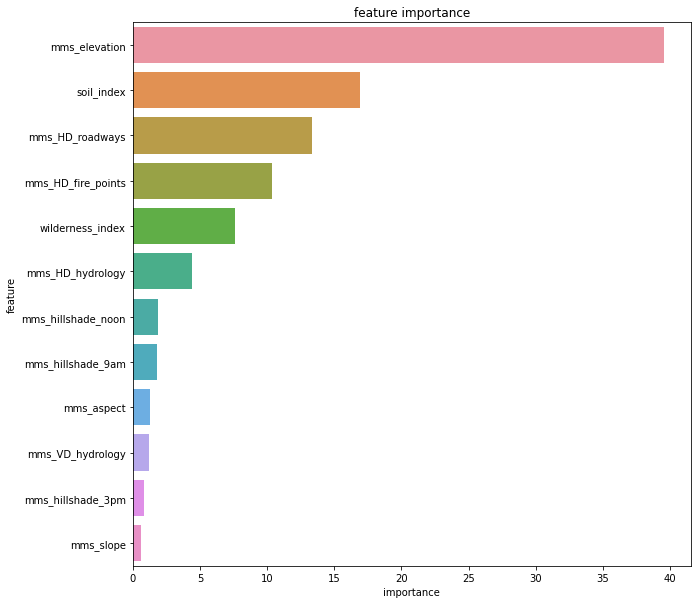

In [114]:
fig, ax = plt.subplots(1,1)
_ = fig.set_figheight(10)
_ = fig.set_figwidth(10)
_ = plt.title('feature importance')

_ = sns.barplot(data=df_cb_features, x='importance', y='feature', ax=ax)

# make plots for models

### scores by class

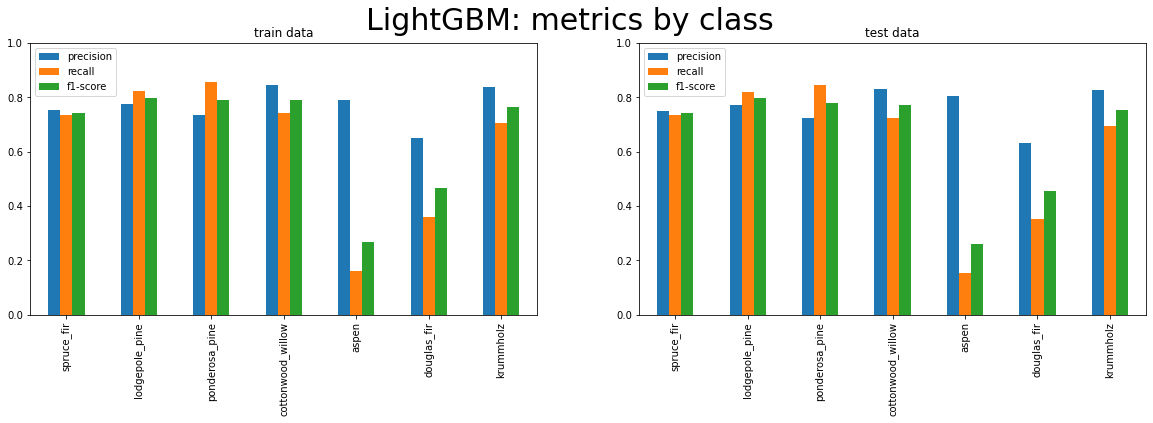

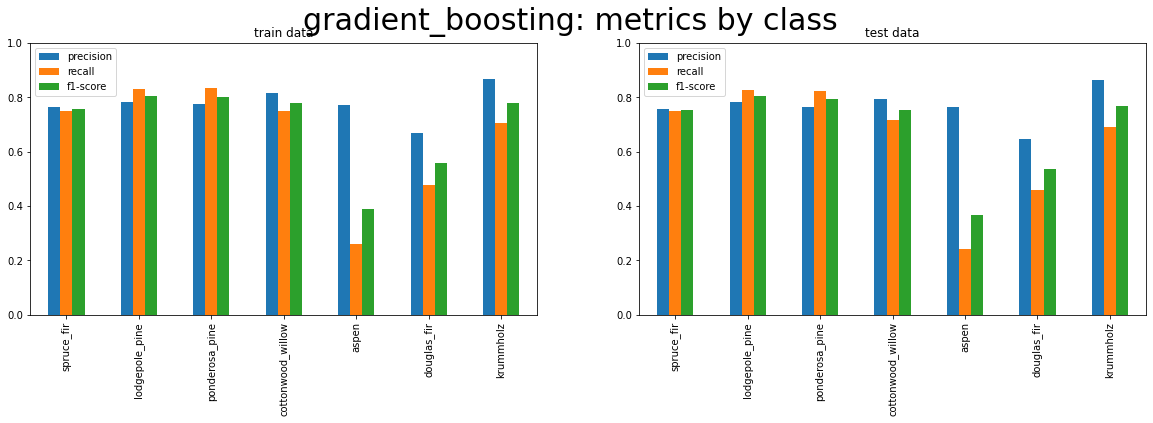

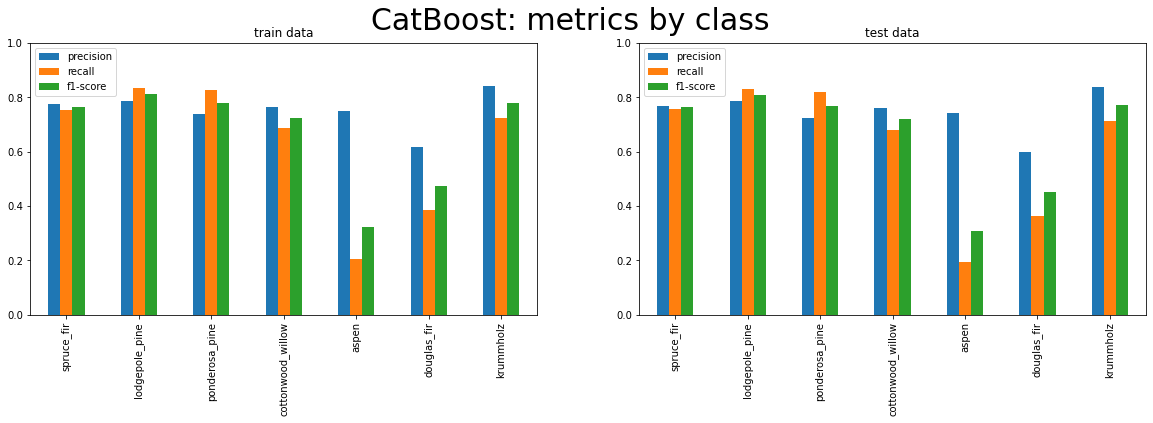

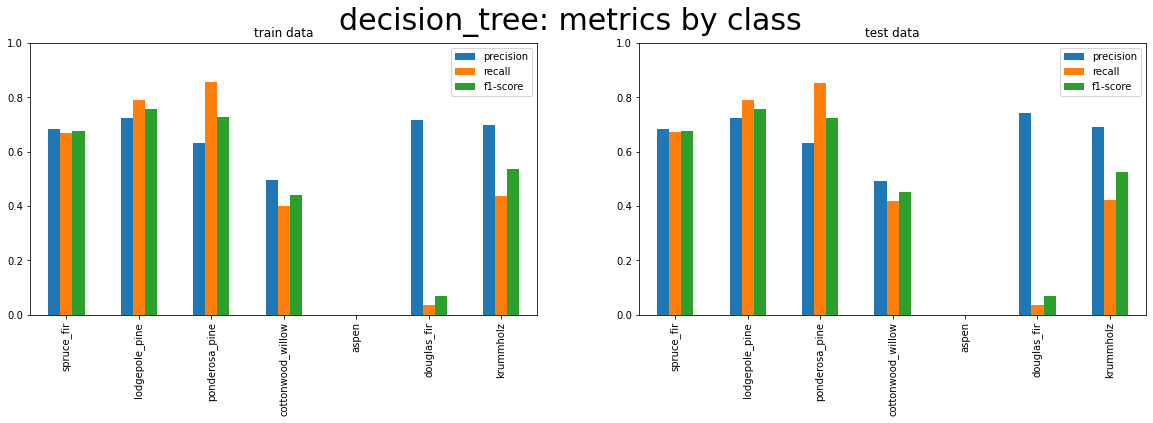

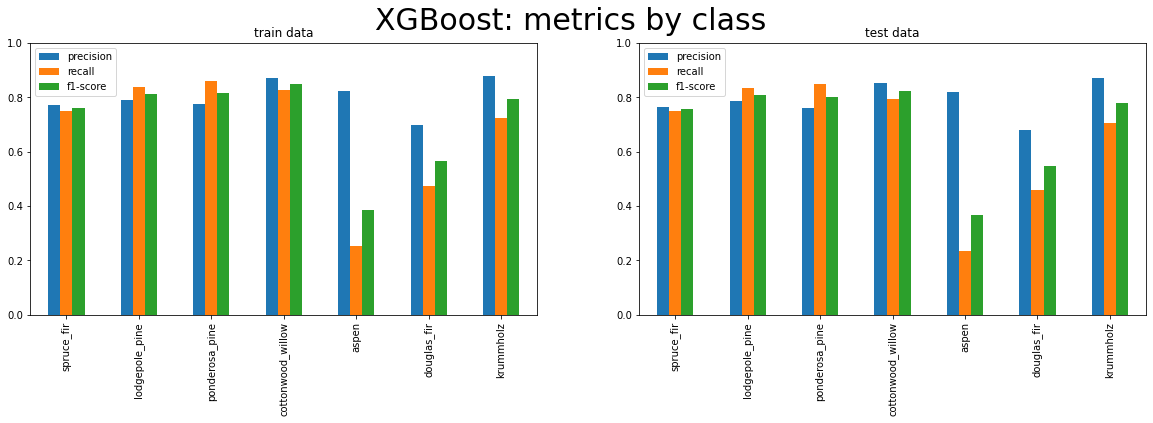

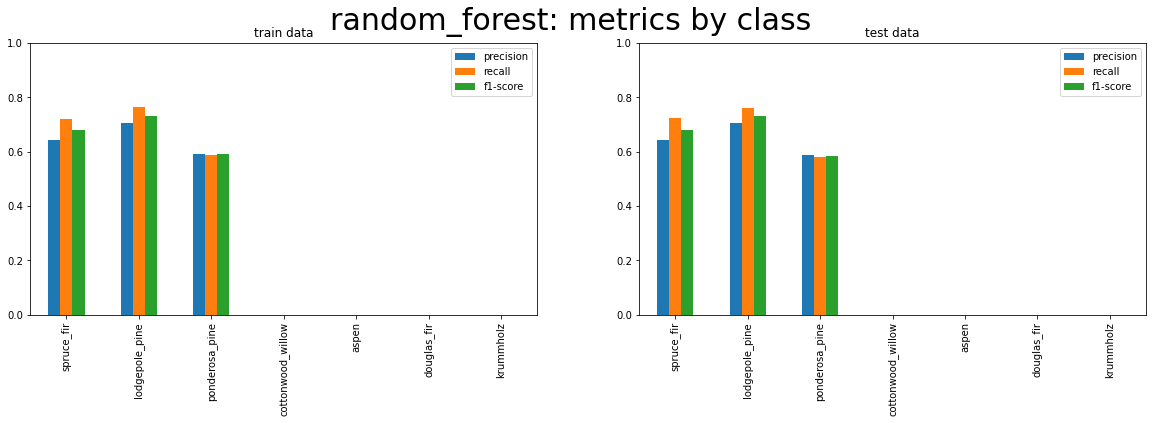

In [115]:
for model in list(df_report_by_class['model'].value_counts().index):
    plot_classification_report(model, df_report_by_class)

### confusion matrices

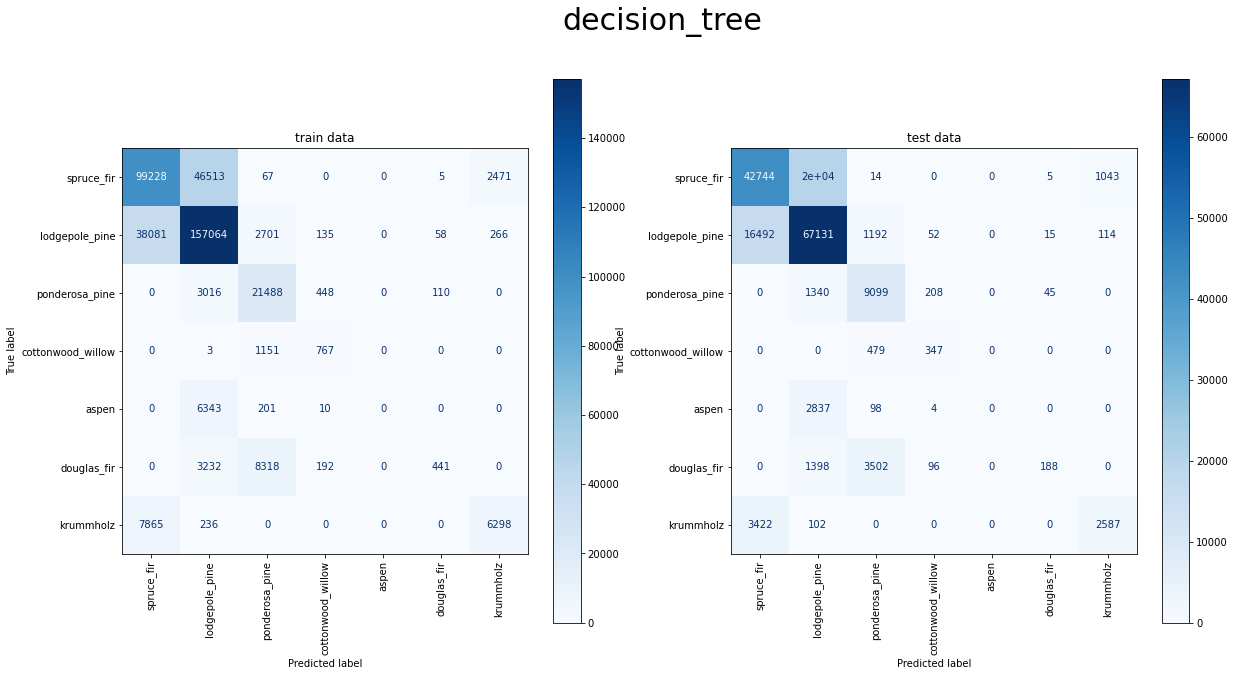

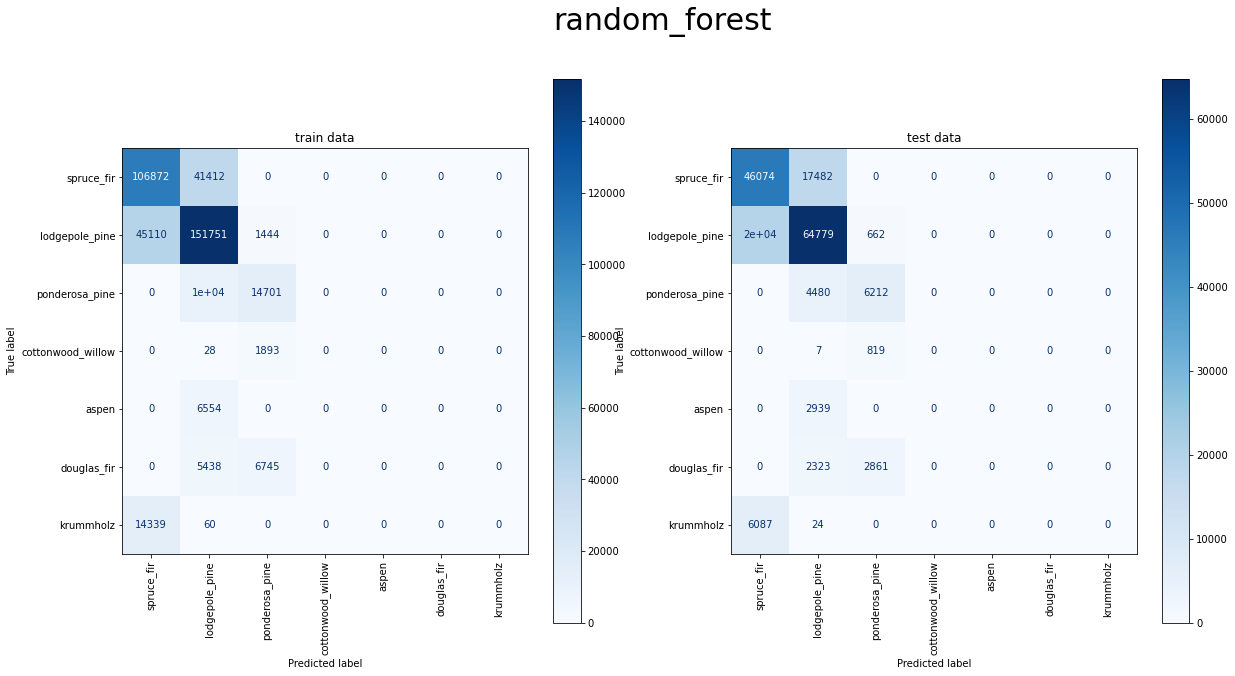

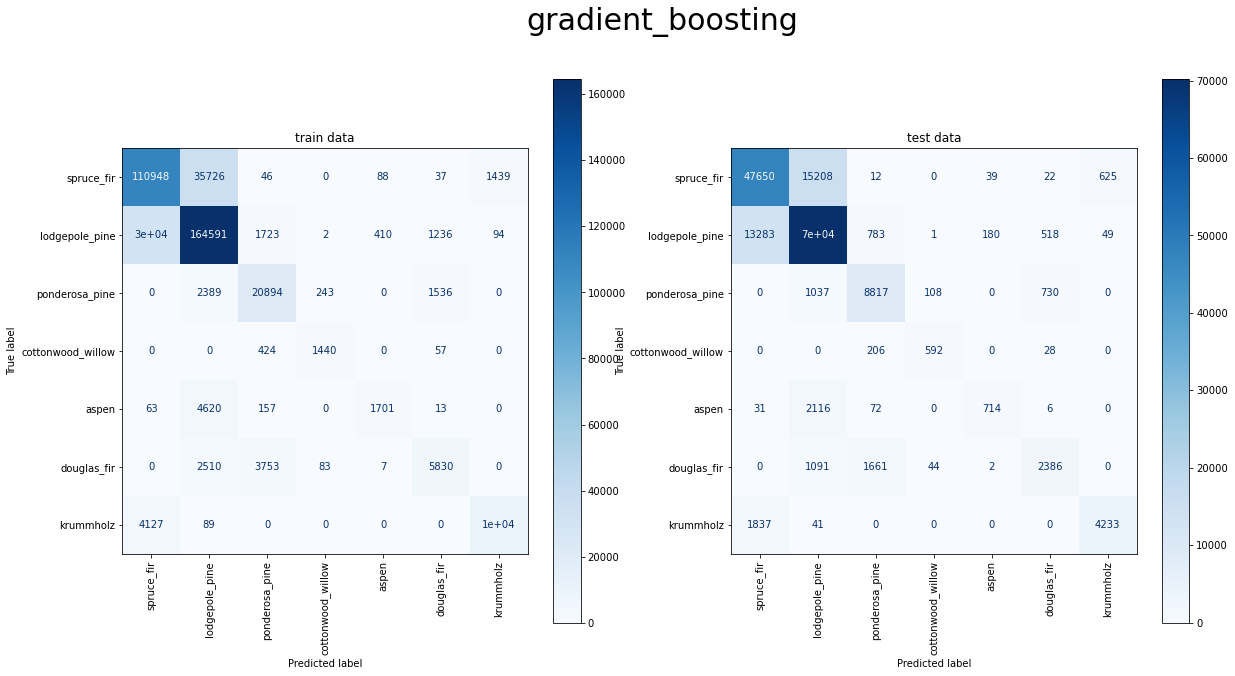

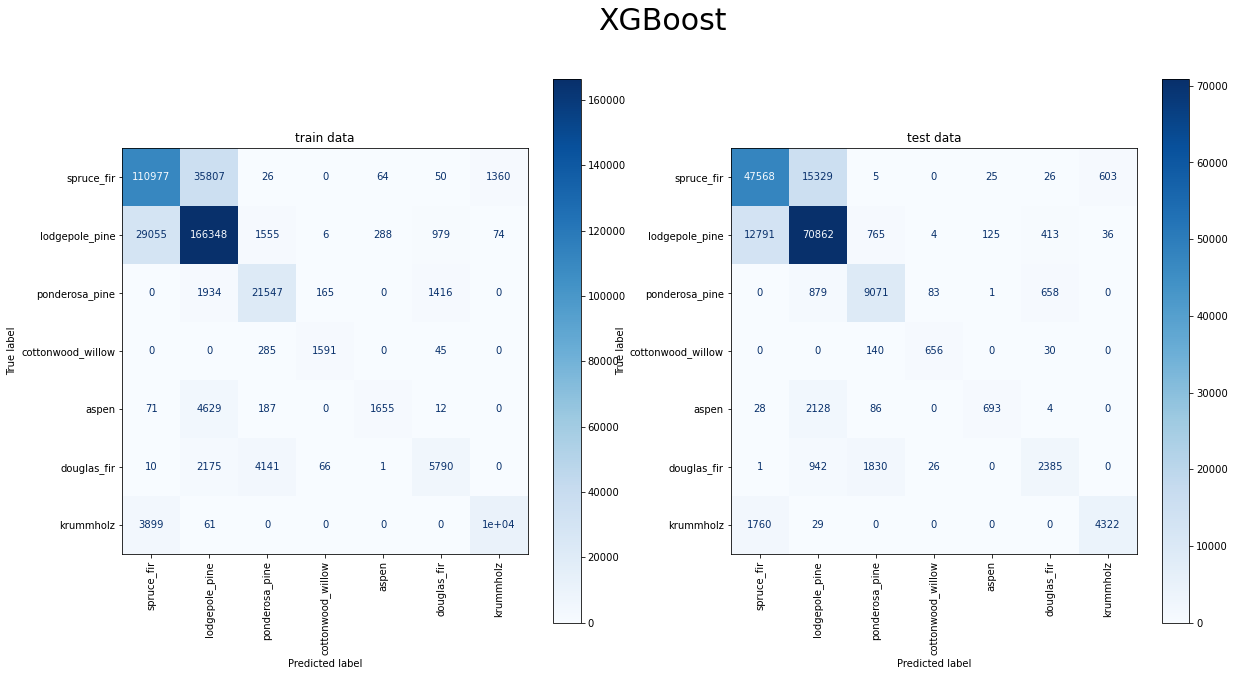

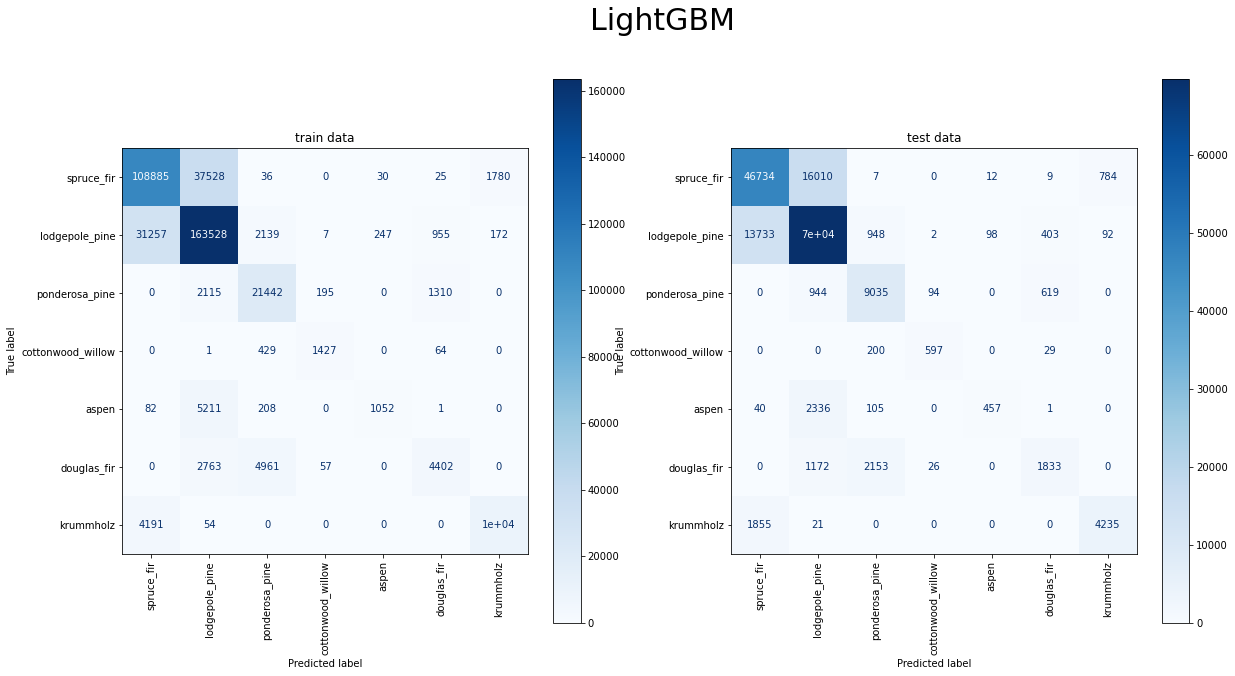

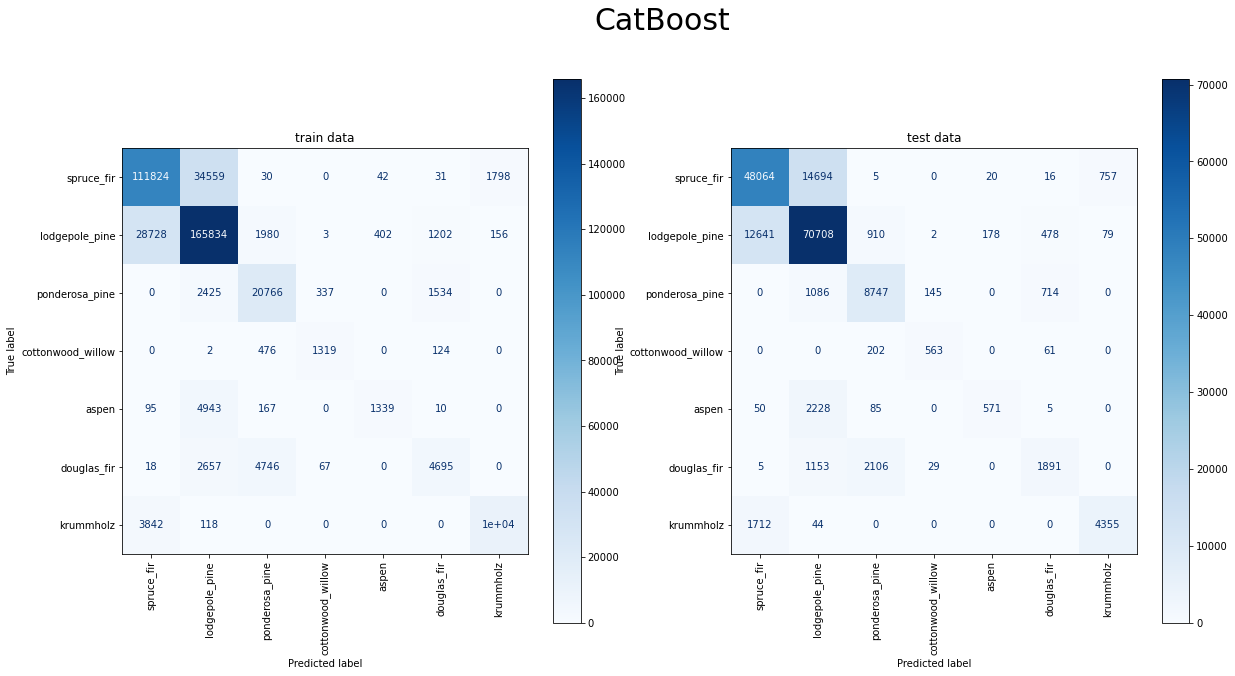

In [116]:
for (key, value) in y_pred_by_model.items():
    plot_confusion_matrices(key, y_train, value['train'], y_test, value['test'], target_names)

### summary of model metrics

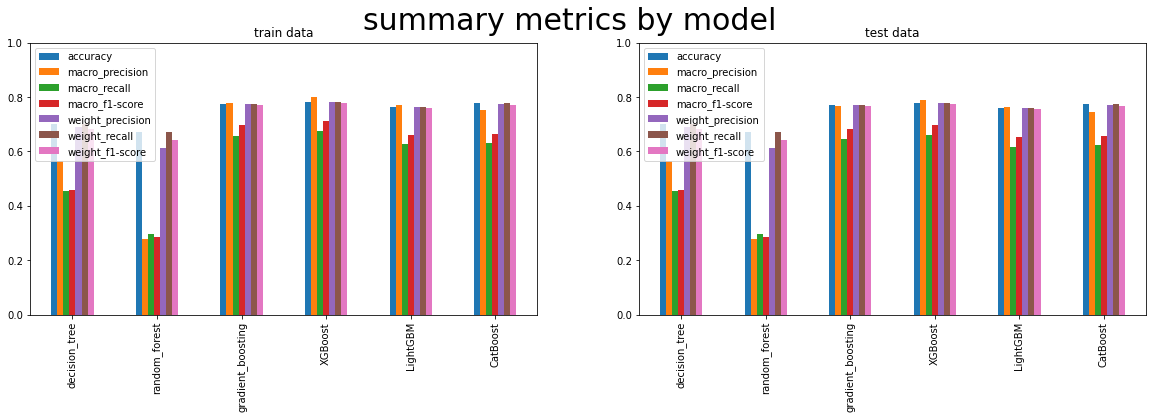

In [117]:
plot_model_summary_metrics(df_report_summary)

### performance on small classes

In [35]:
df_target_dist[['target_name', 'original']].rename(columns={'original':'fraction'}).iloc[2:]

,target_name,fraction
2,ponderosa_pine,0.061537
3,krummholz,0.035300
4,douglas_fir,0.029891
5,aspen,0.016339
6,cottonwood_willow,0.004728


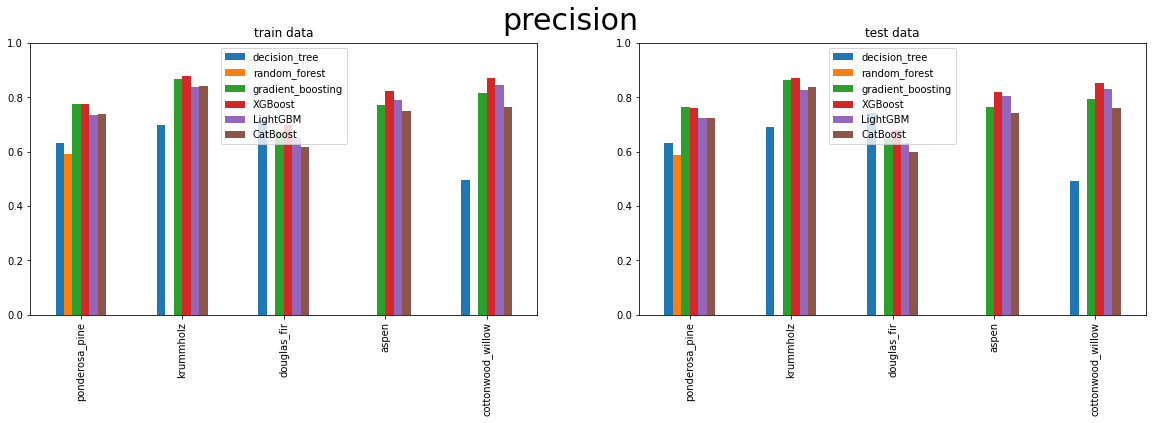

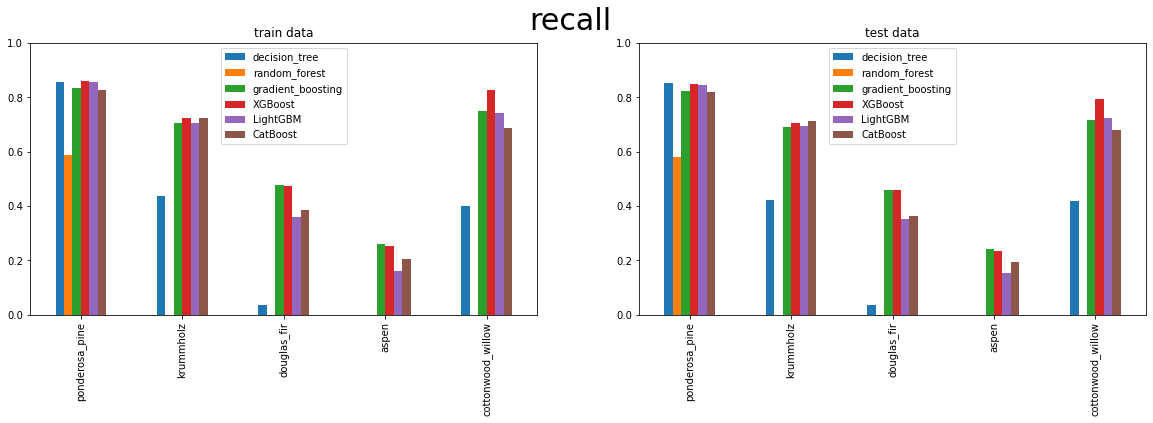

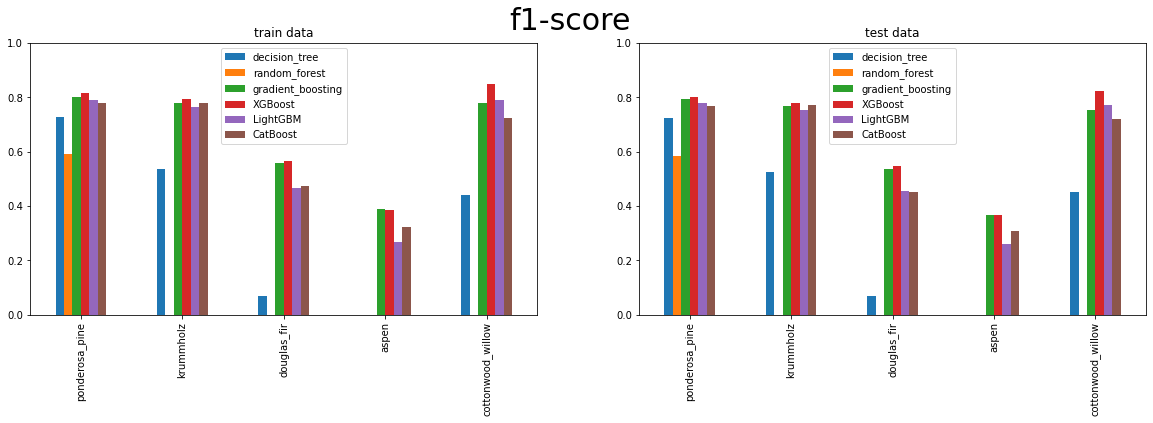

In [118]:
for the_metric in ['precision', 'recall', 'f1-score']:
    plot_small_classes_metric(df_report_by_class, the_metric)

# CONCLUSIONS
overall model peformance
- GB, XGBoost, LightGBM, and CatBoost have almost identical performance
- their performance is better than decision tree and random forest

performance by class
- random forest does not predict any instances of the 4 smallest classes
- decision tree performance on 4 smallest classes is poorer than on 3 largest classes

GB, XGBoost, LightGBM, and CatBoost on 4 smallest classes
- generally have better precision than recall
- XGBoost has slightly better precision and recall than others
- CatBoost generally performs worse than others

LightGBM and CatBoost
- can directly use the 2 categorical features
- very similar performance
- LightGBM slightly better for precision
- CatBoost slightly better for recall

next steps
- parameter tuning for XGBoost and CatBoost

# pickle models

### create dataframe

In [ ]:
df_models_to_pickle = pd.DataFrame(data=zip(list_model_names, list_the_models), columns=['model_name', 'the_model'])
df_models_to_pickle

### write

In [ ]:
df_models_to_pickle.to_pickle('data/tree_models.pkl')

### read file to be sure it's ok

In [ ]:
df_models_read = pd.read_pickle('data/tree_models.pkl')
df_models_read

### try a prediction

In [ ]:
dummy_predict = df_models_read['the_model'][0].predict(X_test)
dummy_predict